In [25]:
import numpy as np
#from scipy.stats import norm
#import numexpr as ne

from tqdm import trange
from tqdm import tqdm
from time import sleep
#from tqdm.notebook import tqdm_notebook
#from rich.progress import Progress
#from rich.progress import track
from IPython.display import Image

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')

/tmp/ipykernel_23034/779088799.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-pastel')


In [33]:
np.sum((np.array([[1,1,1],[1,2,3]]))**2,axis=1)

array([ 3, 14])

In [ ]:
"""
    def __iter__(self):
        return self

    def __next__(self):
        if self.index == 0:
            raise StopIteration
        self.index = self.index - 1
        return self.data[self.index]
"""

In [24]:

def getEnergy( pos, mass, G ):
	"""
	Get kinetic energy (KE) and potential energy (PE) of simulation
	pos is N x 3 matrix of positions
	vel is N x 3 matrix of velocities
	mass is an N x 1 vector of masses
	G is Newton's Gravitational constant
	KE is the kinetic energy of the system
	PE is the potential energy of the system
	"""
	# Potential Energy:

	# positions r = [x,y,z] for all particles
	x = pos[:,0:1]
	y = pos[:,1:2]
	z = pos[:,2:3]

	# matrix that stores all pairwise particle separations: r_j - r_i
	dx = x.T - x
	dy = y.T - y
	dz = z.T - z

	# matrix that stores 1/r for all particle pairwise particle separations 
	inv_r = np.sqrt(dx**2 + dy**2 + dz**2)
	inv_r[inv_r>0] = 1.0/inv_r[inv_r>0]

	# sum over upper triangle, to count each interaction only once
	PE = G * np.sum(np.sum(np.triu(-(mass*mass.T)*inv_r,1)))
	
	return PE;


class  g_sys(g_obj):
    # Newton's Gravitational Constant # km⋅M⊙−1⋅(km/s)**2
    G = 3.086*10**13/233 # approx 4.3009172706*3.086*10**10

    def __init__(self,dt,softening):
        self.dt=dt 
        self.softening=softening
    pass

class g_obj:
    softening=10**(-6) # pc
    def __init__(self,n,type):
        self.pos=np.zeros(n,3)
        self.vel=np.zeros(n,3)
        self.mass=np.zeros(n,1)
        self.type=type

    def set_ic(self,pos_custom,vel_custom,mass_custom):
        self.pos=pos_custom
        self.vel=vel_custom
        self.vel=mass_custom

    def set_cl_ic(self,n,pos_0, R=1., p=np.random.uniform(0,1,(0,3)), soft=softening):
        ip=np.append(p,np.random.uniform(soft,R,(n-len(p),3))*2-R,axis=0)
        fp=np.delete(ip,np.where(np.sum(ip**2,axis=1)>R**2), axis = 0)
        if not len(fp)-n==0:
            return self.set_cl_ic(n, pos_0, R, fp)
        else: 
            return fp+pos_0


/tmp/ipykernel_23034/75501526.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  N_waves = np.int(19)
/tmp/ipykernel_23034/75501526.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more detail

Solo Time: 0.02686786651611328


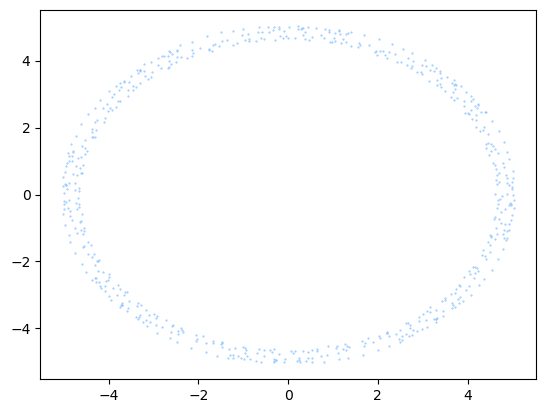

In [23]:

import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
from time import time
from tqdm import tqdm
import multiprocessing as mp
from scipy import interpolate

from numbalsoda import lsoda_sig, lsoda
from numba import cfunc
import numba as nb

"Electric Field Information"
A = np.float32(1.00E-04)
N_waves = np.int(19)
frequency =  np.linspace(37.5,46.5,N_waves)*1e-3 #Set of frequencies used for Electric Field 
m = np.int(20) #Azimuthal Wave Number
sigma = np.float32(0.5) #Gaussian Width of E wave in L
zeta = np.float32(1)

"Particle Information"
N_Particles = np.int(10000)
q = np.float32(-1) #Charge of electron
mass = np.float32(0.511e6) #Mass of Proton eV/c^2
FirstAdiabatic = np.float32(2000e10) #MeV/Gauss Adiabatic Invariant

"Runge-Kutta Paramters"
Total_Time = np.float32(10) #hours
Step_Size = np.float32(0.2) #second 
Plot_Time = np.float32(60) #seconds
time_array = np.arange(0, Total_Time*3600+Step_Size, Step_Size) #Convert to seconds and Add End Point
N_points = len(time_array)

Skip_How_Many = int(Plot_Time/Step_Size) #Used to shorten our data set and save RAM

"Constants"    
Beq = np.float64(31221.60592e-9) #nT
Re = np.float32(6371e3) #Meters
c = np.float32(2.998e8) #m/s

"Start Electric Field Code"
def wave_peak(omega): #Called once so no need to JIT or Optimize this
    L_sample = np.linspace(1,10,100) 
    phidot = -3*FirstAdiabatic / (q* (L_sample*Re)**2 * np.sqrt(1+ (2*FirstAdiabatic*Beq/ (mass*L_sample**3)) ) )
    phidot_to_L = interpolate.interp1d(phidot,L_sample, kind = 'cubic')
    L0i = phidot_to_L(omega/m)
    return L0i 
omega = 2*np.pi*frequency
L0i_wave = wave_peak(omega)
Phi0i_wave = np.linspace(0,2*np.pi,N_waves)
np.random.shuffle(Phi0i_wave)

@njit(parallel=True)
def Electric_Field(t,r):
    E0 = A*np.exp(-(r[0]-L0i_wave)**2 / (2*sigma**2))
    Delta = np.arctan2( (r[0] * (r[0]-L0i_wave)/sigma**2 - 1), (2*np.pi*r[0]/zeta) )
    Er = E0/m * np.sqrt( (2*np.pi*r[0]/zeta)**2 + (r[0]*(r[0]-L0i_wave)/sigma**2 -1)**2 ) * np.cos(m*r[1] - omega*t + Phi0i_wave + 2*np.pi*r[0]/zeta + Delta)
    Ephi = E0*np.cos(m*r[1] - omega*t + Phi0i_wave + 2*np.pi*r[0]/zeta)
    return np.sum(Er),np.sum(Ephi)
"End of Electric Field Code"

"Particle's ODE - Equation of Motion"
@cfunc(lsoda_sig)
def ODE(t, r_, dr, p):
    r = nb.carray(r_, (2,))
    Er, Ephi = Electric_Field(t,r)
    Ldot = Ephi * r[0]**3 / (Re*Beq)
    Phidot = -Er * r[0]**2 / (Re*Beq) - 3* FirstAdiabatic / (q*r[0]**2*Re**2) * 1/np.sqrt(2*FirstAdiabatic*Beq/ (r[0]**3*mass) + 1)
    dr[0] = Ldot
    dr[1] = Phidot
funcptr = ODE.address
    
@njit(parallel=True)
def Motion(L0,Phi0):
    u0 = np.array([L0,Phi0],np.float64)
    data = np.array([5.0])
    usol, success = lsoda(funcptr, u0, time_array, data)
    L_Array = usol[:,0]
    Phi_Array = usol[:,1]
    return L_Array[::Skip_How_Many], Phi_Array[::Skip_How_Many]
    #Skip_How_Many is used to take up less RAM space since we don't need that kind of percsion in our data

Location = Motion(5,0)
x = Location[0]*np.cos(Location[1])
y = Location[0]*np.sin(Location[1])
plt.plot(x,y,"o", markersize = 0.5)
ts = time()
Motion(5,0)
print('Solo Time:', time() - ts)
